In [1]:
# This was protoype code when we were still learning what the hell we were doing. We were able to generate some 
# geopandas maps. Nothing much to see, but we figures it was documentation of the work and sweat we've put into this.

In [2]:
import pandas as pd
import numpy as np
from heapq import nlargest
 
# Calculates the delta as number of bikes incoming/outgoing at previous hour
# The higher the delta, the more bikes in the station
def setDelta(station_id, hour, data, delta):
    # Find tours coming to this station previous hour
    incoming = data[data['end station id'] == station_id]
    outgoing = data[data['start station id'] == station_id]
    assert(len(incoming) != 0)
    assert(len(outgoing) != 0)
 
    # Find tours coming/leaving this station previous hour
    if(hour == 0):
        incoming = incoming[incoming['Time'] == 2300]
        outgoing = outgoing[outgoing['Time'] == 2300]
    else:
        hour -= 1;
        hour *= 100; # HACK, Times are 100 multiplied!!
        incoming = incoming[incoming['Time'] == hour]
        outgoing = outgoing[outgoing['Time'] == hour]
 
    # assert(len(incoming) != 0)
    # assert(len(outgoing) != 0)
 
    # Set the difference of coming/going
    delta.append(len(incoming) - len(outgoing))
 
# Given nhood id and hour in [0...23]
# Returns data frame including top k highest likely stations to find a bike.
# The higher the delta, the more higher the chance to find bike
# The headers of the data frame is "delta", "station id", "latitude", "longitude"
def getDelta(nhood, hour, k, busiest = 'largest'):
 
    data = pd.read_csv('Merged Data/Merged_July_2016_Bike.csv')
    stations = pd.read_csv('./stations.csv')
 
    # Stations in the given neighborhood
    # Mask keeps the original indices
    statsInNhood = stations[['station id', 'latitude', 'longitude']][stations['nhood id'] == nhood]
    # print(len(statsInNhood.unique()))
    # print(len(statsInNhood))
 
    # For every station, find coming/going delta
    delta = []
    statsInNhood.apply(lambda row: setDelta(row['station id'], hour, data, delta), axis=1)
 
    # # print(len(delta))
    statsDelta = pd.DataFrame({"station id": statsInNhood['station id'].tolist(),
                               "delta": delta,
                               "latitude": statsInNhood['latitude'].tolist(),
                               "longitude":statsInNhood['longitude'].tolist()})
    # print(statsDelta)
 
    # Return top-k highest delta (meaning more bikes)
    if busiest == 'largest':
        return statsDelta.nlargest(k, 'delta')
    else:
        return statsDelta.nsmallest(k,'delta')
 
best = getDelta(2, 10, 10, busiest = 'largest')
print(best)

    delta   latitude  longitude  station id
8     313  40.722104 -73.997249         151
20    201  40.702551 -73.989402        2000
35    184  40.702819 -73.987658         414
18    132  40.701485 -73.986569         430
27    132  40.716021 -73.999744         355
2     131  40.692362 -73.986317         323
17    117  40.707873 -74.001670         279
59    100  40.688226 -73.979382         243
52     73  40.692216 -73.984284         390
38     64  40.699918 -73.989718         321


In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt


def make_point(row):
    return Point(row['longitude'], row['latitude'])

#Takes a data frame and returns a GeoDataFrame with the same data, and 
#where the long/lat point are the 'geometry' for the GeoDataFrame
def make_geoframe(df):
    points = df.apply(make_point, axis=1)
    gdf = gpd.GeoDataFrame(df, geometry = points)
    #Define CRS
    gdf.crs = {'init': 'epsg:4326'}
    return gdf
# ten_gdf = make_geoframe(getDelta(2, 10, 10))
# twenty_gdf = make_geoframe(getDelta(2,10,20))

In [5]:
#Creates a Geodataframe where the geometry is defined by Zipcode
def Zip_Code_Map():
    coord_system = {'init': 'epsg:4326'}
    gdf = gpd.read_file('ZIP_CODE_040114/ZIP_CODE_040114.shp').to_crs(coord_system)
    
    # Only keep boroughs where there are no city bikes
    gdf = gdf.loc[gdf['COUNTY'].isin(['Queens','New York', 'Kings'])]
    return gdf
base = Zip_Code_Map()


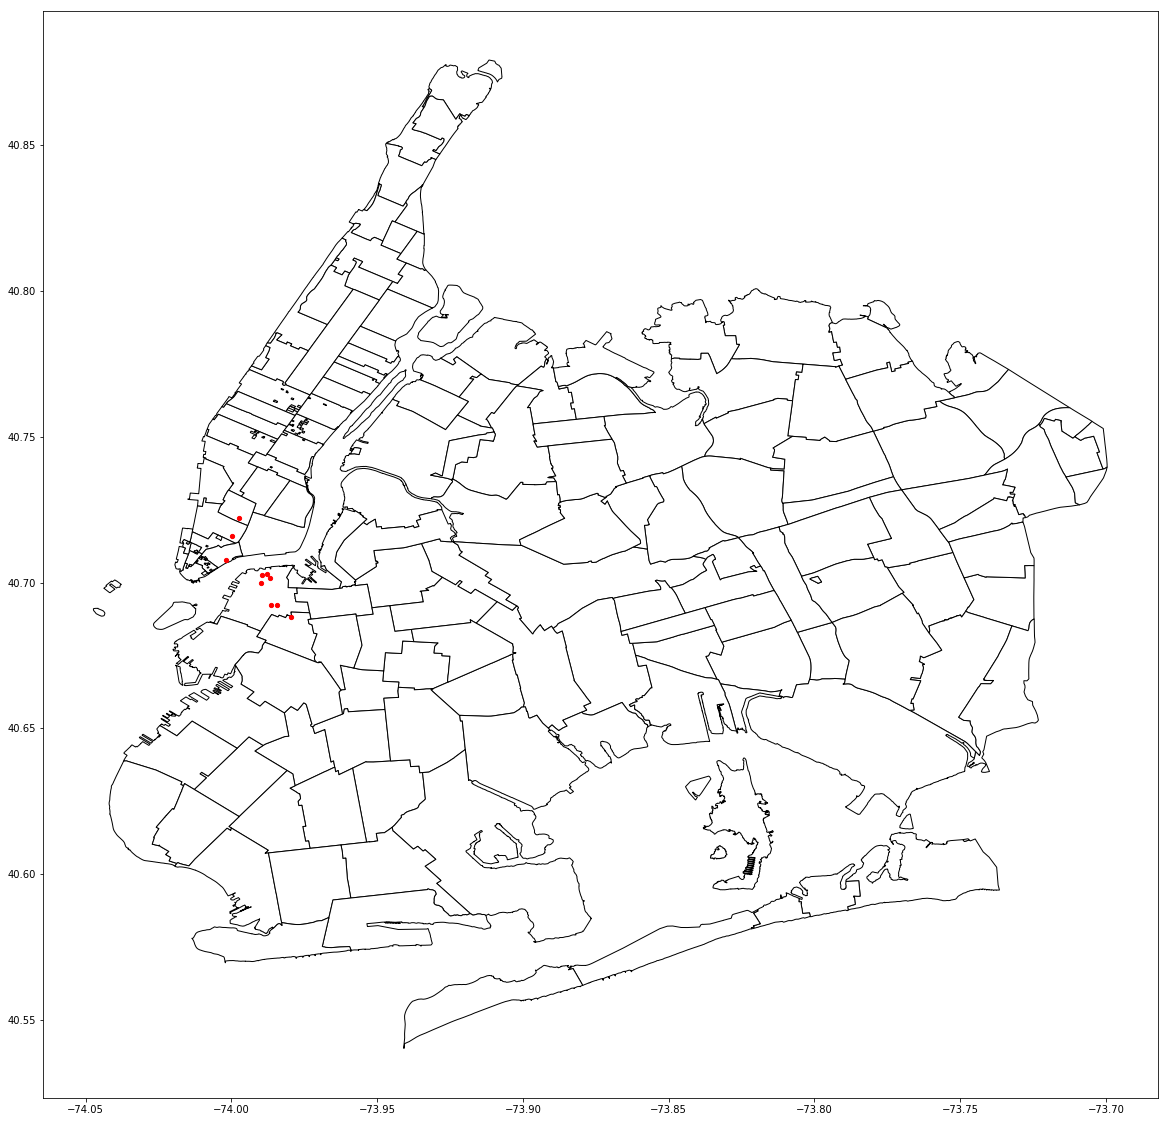

In [18]:
#Takes a list of GeoDataFrames (data is a list of geoframes), a base_map, and number of optional 
#paramters and populates the base map with the GeoDataFrame entries. 
def Populate_Map(data, base_map, data_color = ['red'], size1=500, size2 = 20):
    fig, ax = plt.subplots(figsize = (size1, size2))
    ax.set_aspect('equal')
    base_map.plot(ax=ax, color='white', edgecolor='black')
    for i in range(len(data)):
        data[i].plot(ax=ax, marker='o', color=data_color[i], markersize=18)
    plt.show()
 
Populate_Map([ten_gdf],base) 

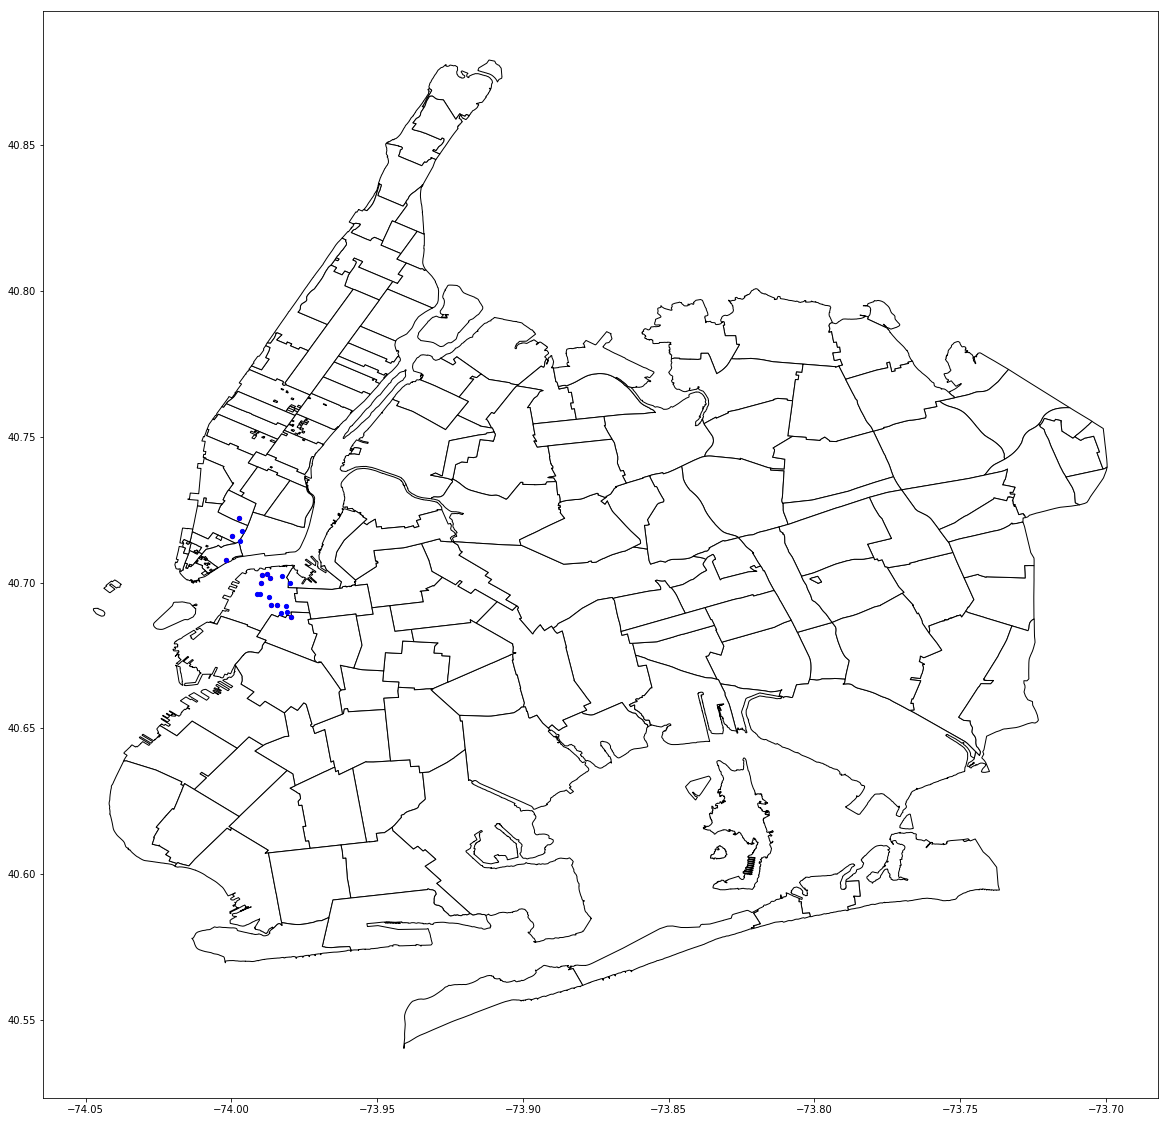

In [25]:
data = [ten_gdf, twenty_gdf]
colors = ['red', 'blue']
Populate_Map(data, base, data_color = colors)

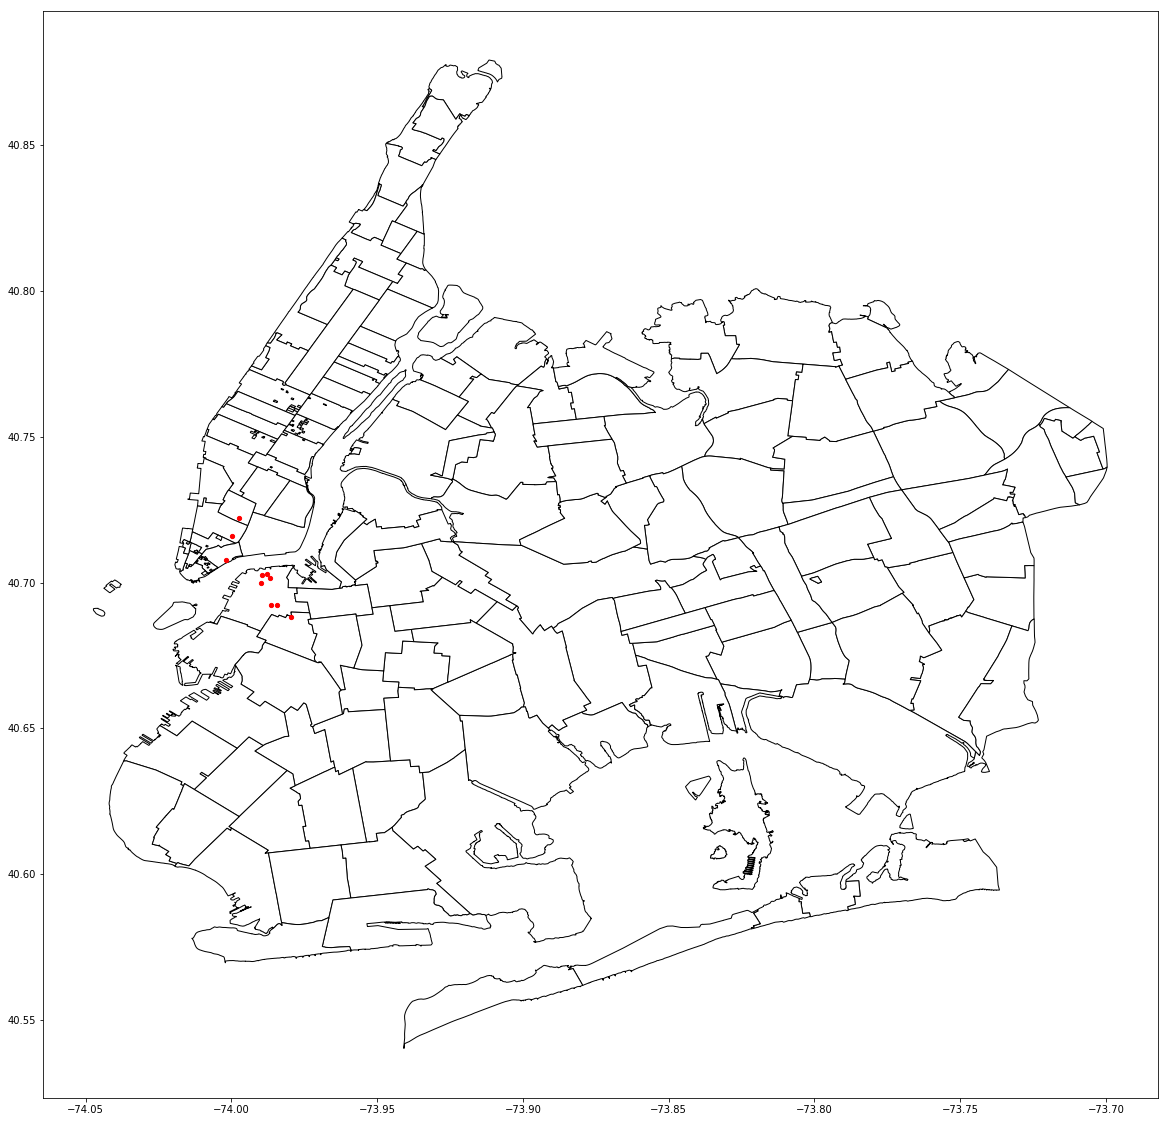

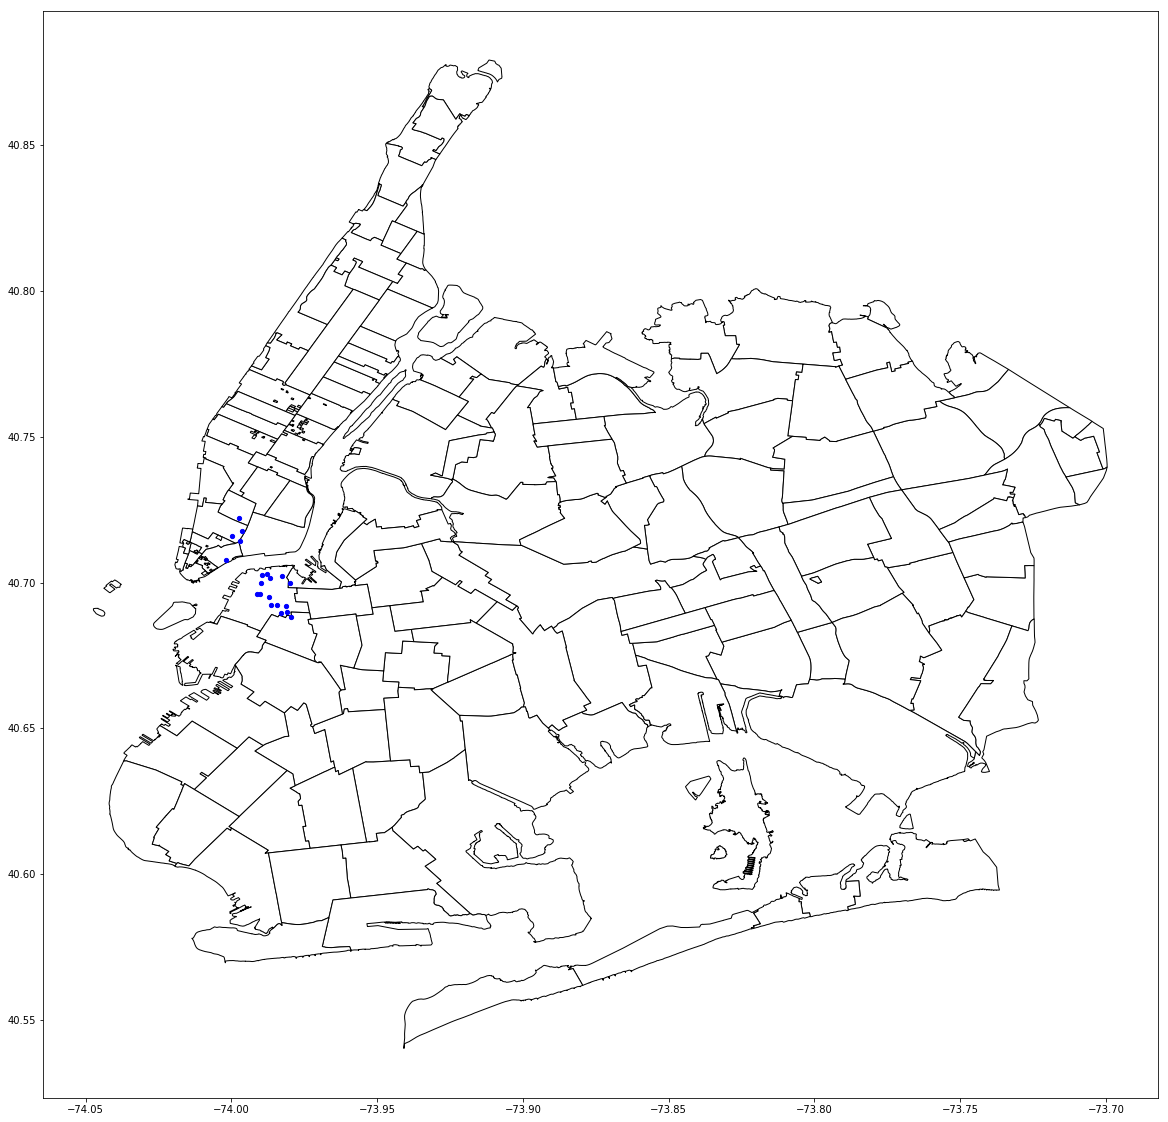

In [24]:
data = [ten_gdf, twenty_gdf]
colors = ['red', 'blue']
Populate_Map([ten_gdf], base)
Populate_Map([twenty_gdf], base, data_color = colors[1])

In [7]:
#Takes a list of GeoDataFrame with long/lat points, a base_map, and number of optional 
#paramters and creates a heat map based on where the points lie on the map. 
def Heat_Map(data,column ,base_map, color = 'OrRd', size1=500, size2 = 20):
    geo = base_map.geometry
    heat = data[column]
    heat = heat.reset_index(drop=True)
    points = make_geoframe(data).geometry
    pop = np.zeros(shape=len(geo))
    base_map_pop = base_map
    cum_count = 0
    for j in geo:
        count = 0
        for i in points:
            if j.contains(i):
                pop[cum_count] += column[count]
                count += 1
            else:
                count += 1
        cum_count += 1
    base_map_pop['pop'] = pd.Series(pop, index=base_map.index)
    base_map_pop.plot(column='pop', cmap = color, figsize = (size1, size2));
    plt.show()

In [2]:
import pandas as pd
import numpy as np
from heapq import nlargest
x = pd.read_csv('Income and Bike Id/december_med_bike_id.csv')
x.columns

Index(['tripduration', 'start station id', 'start station name',
       'start station latitude', 'start station longitude', 'end station id',
       'end station name', 'end station latitude', 'end station longitude',
       'usertype', 'birth year', 'gender', 'start_time', 'stop_time', 'date',
       'time', 'humidity', 'tempf', 'weatherdesc', 'windspeedmiles', 'day',
       'start point', 'end point', 'start neighborhood', 'start borough',
       'start median income', 'end neighborhood', 'end borough',
       'end median income', 'bikeid'],
      dtype='object')